# 第四章 神经网络工具箱nn

autograd实现了自动微分系统，然而对于深度学习来说过于底层，本章将介绍的nn模块，是构建于autograd之上的神经网络模块。除了nn之外，我们还会介绍神经网络中常用的工具，比如优化器optim、初始化init等。

## 4.1 nn.Module

第三章中提到，使用autograd可实现深度学习模型，但其抽象程度较低，如果用其来实现深度学习模型，则需要编写的代码量极大。在这种情况下，torch.nn便应运而生，它是专门为深度学习而设计的模块。torch.nn的核心数据结构是`Module`，它是一个抽象的概念，既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络。在实际使用中，最常见的做法是继承`nn.Module`，从而编写自己的网络/层。下面先来看看如何用`nn.Module`实现自己的全连接层。全连接层，又名仿射层，输出$\textbf{y}$和输入$\textbf{x}$满足$\textbf{y=Wx+b}$，其中$\textbf{W}$和$\textbf{b}$是可学习的参数。

In [1]:
import torch as t
from torch import nn
print(t.__version__)

1.6.0


In [2]:
class Linear(nn.Module): # 继承nn.Module，必须重写构造函数（__init__)和前向传播函数（forward）
    def __init__(self, in_features, out_features):
        super().__init__() # 等价于nn.Module.__init__(self)，常用super方式
        # nn.Parameter内的参数是网络可学习的参数
        self.w = nn.Parameter(t.randn(in_features, out_features))
        self.b = nn.Parameter(t.randn(out_features))
    
    def forward(self, x):
        x = x.mm(self.w) # 矩阵乘法，等价于x.@(self.w)
        return x + self.b.expand_as(x)

In [3]:
layer = Linear(4,3)
input = t.randn(2,4)
output = layer(input)
output

tensor([[-1.0987, -0.2932, -3.5264],
        [-0.0662, -5.5573, -8.1498]], grad_fn=<AddBackward0>)

In [4]:
for name, parameter in layer.named_parameters():
    print(name, parameter) # w and b 

w Parameter containing:
tensor([[ 0.5180,  1.4337,  0.4373],
        [ 0.2299, -1.6198, -0.7570],
        [ 0.0694, -1.7724, -0.2443],
        [ 0.0258,  0.1944,  3.4072]], requires_grad=True)
b Parameter containing:
tensor([-0.4774,  1.4022, -1.4314], requires_grad=True)


从上面的例子中可以看出，全连接层的实现非常简单，其代码量不超过10行，但需注意以下几点：
- 自定义层`Linear`必须继承`nn.Module`，并且在其构造函数中需调用`nn.Module`的构造函数，即`super().__init__()` 或`nn.Module.__init__(self)`，推荐使用第一种用法；
- 在构造函数`__init__`中必须自行定义可学习的参数，并封装成`Parameter`，如在本例中我们把`w`和`b`封装成`Parameter`。`Parameter`是一种特殊的`Tensor`，但其默认需要求导（requires_grad = True），感兴趣的读者可以通过`nn.Parameter??`，查看`Parameter`类的源代码；
- `forward`函数实现前向传播过程，其输入可以是一个或多个Tensor；
- 无需写反向传播函数，`nn.Module`能够利用autograd自动实现反向传播，这点比Function简单许多；
- 使用时，直观上可将layer看成数学概念中的函数，调用layer(input)即可得到input对应的结果。它等价于`layers.__call__(input)`，在`__call__`函数中，主要调用的是 `layer.forward(x)`，另外还对钩子（hook）做了一些处理。所以在实际使用中应尽量使用`layer(x)`而不是使用`layer.forward(x)`，关于钩子技术将在下文讲解；
- `Module`中的可学习参数可以通过`named_parameters()`或者`parameters()`返回一个迭代器，前者会给每个parameter都附上名字，使其更具有辨识度。

可见利用Module实现的全连接层，比利用`Function`实现的更为简单，这是因为我们不再需要编写反向传播函数。

Module能够自动检测到自己的`parameter`，并将其作为学习参数。除了`parameter`之外，Module还包含子`Module`，主Module能够递归查找子`Module`中的`Parameter`。下面再来看看稍微复杂一点的网络，多层感知机。

多层感知机的网络结构如图4-1所示，它由两个全连接层组成，采用$sigmoid$函数作为激活函数（图中没有画出）。
![图4-1；多层感知机](imgs/multi_perceptron.png)

In [5]:
class Perceptron(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(Perceptron, self).__init__()
        # 此处的Linear是前面自定义的全连接层
        self.layer1 = Linear(in_features, hidden_features) 
        self.layer2 = Linear(hidden_features, out_features)
    def forward(self, x):
        x = self.layer1(x)
        x = t.sigmoid(x)
        return self.layer2(x)

In [6]:
perceptron = Perceptron(3,4,1)
for name, param in perceptron.named_parameters():
    print(name, param.size())

layer1.w torch.Size([3, 4])
layer1.b torch.Size([4])
layer2.w torch.Size([4, 1])
layer2.b torch.Size([1])


可见，即使是稍复杂的多层感知机，其实现依旧很简单。需要注意的是，在构造函数`__init__`中，可利用前面自定义的Linear层(module)，作为当前module对象的一个子module，它的可学习参数，也会成为当前module的可学习参数。而在`forward`函数中，可以加上各层之间的处理函数（激活、数学处理等），并决定层与层之间的关系。

而在module中，parameter的全局命名规范如下：

1. Parameter直接命名。例如`self.param_name = nn.Parameter(t.randn(3, 4))`，直接命名为`param_name`；
2. 子Module中的parameter，会在其名字之前加上当前module的名字。例如`self.sub_module = SubModel()`，SubModel中有个parameter的名字叫做param_name，那么二者拼接而成的parameter name 就是`sub_module.param_name`。

为方便用户使用，PyTorch内部实现了神经网络中绝大多数的layer，这些layer都继承于`nn.Module`，封装了可学习参数`parameter`，并实现了`forward`函数。同时，大部分layer都专门针对GPU运算进行了CuDNN优化，其速度和性能都十分优异。本书不准备对nn.Module中的所有层进行详细介绍，具体内容读者可参照官方文档或在IPython/Jupyter中使用nn.layer?来查看。读者在阅读文档时应主要关注以下几点：

1. 构造函数的参数，如nn.Linear(in_features, out_features, bias)，需关注这三个参数的作用；
2. 属性、可学习参数和子module。如nn.Linear中有`weight`和`bias`两个可学习参数，不包含子module；
3. 输入输出的形状，如nn.linear的输入形状是(N, input_features)，输出为(N，output_features)，其中N是batch_size。

这些自定义layer对输入形状都有假设：输入的不是单个数据，而是一个batch。当输入只有一个数据时，则必须调用`tensor.unsqueeze(0)`或`tensor[None]`将数据伪装成`batch_size=1`的一个batch。

[^1]: http://pytorch.org/docs/nn.html

下面将从应用层面出发，对一些常用的layer做简单介绍，更详细的用法请查看官方文档。

## 4.2 常用神经网络层

本节将对神经网络中常用的神经网络层进行介绍，这部分内容在后续神经网络的构建中将发挥着重要的作用。

### 4.2.1 图像相关层

图像相关层主要包括卷积层（Conv）、池化层（Pool）等，这些层在实际使用中可分为一维（1D）、二维（2D）和三维（3D），池化方式又分为平均池化（AvgPool）、最大值池化（MaxPool）、自适应池化（AdaptiveAvgPool）等。而卷积层除了常用的前向卷积之外，还有逆卷积（TransposeConv）等等。下面将举例说明。

#### 卷积层

在深度学习中，与图像处理相关的网络结构中最重要的便是卷积层(Conv)。卷积神经网络的本质就是卷积层、池化层、激活层以及其他层的叠加，所以理解卷积层的工作原理是极其重要的。本节将以最常见的二维卷积为例来对卷积层进行说明。

在torch.nn工具箱中，已经封装好了二维卷积类 ： 
```python
torch.nn.Conv2d(in_channels: int,   
                out_channels: int,  
                kernel_size: Union[T, Tuple[T, T]], 
                stride: Union[T, Tuple[T, T]] = 1, 
                padding: Union[T, Tuple[T, T]] = 0, 
                dilation: Union[T, Tuple[T, T]] = 1, 
                groups: int = 1, bias: bool = True, 
                padding_mode: str = 'zeros')  
```
其中：  
- in_channels：输入图像的维度（常见RGB彩色图像为3）；
- out_channels：经过卷积操作后输出的维度；
- kernel_size：卷积核大小，常见卷积核为2维方阵即维度为$[T\times T]$，正方形卷积核可以写为$T(int)$；
- stride：每次卷积操作移动的步长；
- padding：卷积操作在边界是否有填充，默认为0；
- bias：卷积操作加上偏置作为可学习参数，默认为True。


在卷积操作中，我们需要知道其输出结果的形状，以便对后续网络结构进行设计。假设输入的形状为$（N,C_{in},H_{in},W_{in})$，输出的形状为$（N,C_{out},H_{out},W_{out})$，则可以通过式(4.1)计算：
$$ \begin{array}{l}
   H_{out} = \lfloor {H_{in}+{2}\times{padding[0]}-kernel\_size[0] \over stride[0]}+1 \rfloor \\
   W_{out} = \lfloor {W_{in}+{2}\times{padding[1]}-kernel\_size[1] \over stride[1]}+1 \rfloor
  \end{array}\tag{4.1}
$$ 
下面将举例说明卷积操作的具体过程。

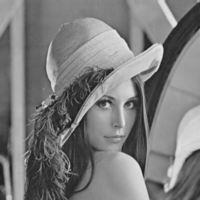

In [7]:
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
to_tensor = ToTensor() # img -> tensor
to_pil = ToPILImage()
lena = Image.open('imgs/lena.png')
lena#将lena可视化输出

Input Size: torch.Size([1, 1, 200, 200])
Output Size: torch.Size([1, 1, 198, 198])


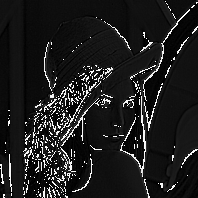

In [8]:
# 输入是一个batch，batch_size＝1
lena = to_tensor(lena).unsqueeze(0) 
print("Input Size:",lena.size())#查看input纬度
# 锐化卷积核
kernel = t.ones(3, 3) / (-9.)
kernel[1][1] = 1
conv = nn.Conv2d(1, 1, (3, 3), 1, bias=False)
conv.weight.data = kernel.view(1, 1, 3, 3)

out = conv(lena)
print("Output Size:",out.size())
to_pil(out.data.squeeze(0))

在上面的例子中，输入Tensor的大小为$200\times 200$，卷积核大小为$3\times 3$，步长为1，填充为0，则根据式(4.1)可以计算得到输出的形状为：
$$
H_{out}=W_{out} = \lfloor {200+{2}\times{0}-3 \over 1 }+1\rfloor=198
$$
这与程序输出的维度一致。

这里我们以二维卷积为例对卷积层的输入输出进行了基本的介绍。除了二维卷积以外，图像的卷积操作还有各种变体，感兴趣的读者可以进一步查阅相关资料。

#### 池化层

池化层可以看作是一种特殊的卷积层，其主要用于下采样，增加池化层可以在保留主要特征的同时降低参数量，从而一定程度上防止了过拟合。池化层没有可学习参数，它的weight是固定的。在`torch.nn`工具箱中封装好了各种池化层，常见的有最大池化（MaxPool）和平均池化（AvgPool)，下面将举例说明。

In [9]:
input = t.randint(10,(1,1,4,4))
print(input)
pool = nn.AvgPool2d(2,2) # 平均池化，池化中的卷积核为2*2，步长默认等于卷积核长度，无填充
pool(input)

tensor([[[[6, 8, 9, 2],
          [0, 3, 1, 4],
          [7, 0, 9, 9],
          [9, 3, 2, 7]]]])


tensor([[[[4, 4],
          [4, 6]]]])

In [10]:
list(pool.parameters()) # 可以看到，池化层中并没有可学习参数。

[]

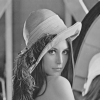

In [11]:
out = pool(lena)
to_pil(out.data.squeeze(0))#输出池化后的lena

#### 其他层

除了卷积层和池化层，深度学习中还将常用到以下几个层：
- Linear：全连接层；
- BatchNorm：批标准化层，分为1D、2D和3D。除了标准的BatchNorm之外，还有在风格迁移中常用到的InstanceNorm层；
- Dropout：Dropout层，用来防止过拟合，同样分为1D、2D和3D。

下面将举几个例子来说明它们的使用方法。

In [12]:
# 输入 batch_size=2，维度3
input = t.randn(2, 3)
linear = nn.Linear(3, 4)
h = linear(input)
h

tensor([[-0.2782, -0.7852,  0.0166, -0.1817],
        [-0.1064, -0.5069, -0.2169, -0.0372]], grad_fn=<AddmmBackward>)

In [13]:
# 4 channel，初始化标准差为4，均值为0
bn = nn.BatchNorm1d(4)
bn.weight.data = t.ones(4) * 4
bn.bias.data = t.zeros(4)

bn_out = bn(h)
print(bn_out)
# 注意输出的均值和方差
bn_out.mean(0),bn_out.std(0, unbiased=False)

tensor([[-3.9973, -3.9990,  3.9985, -3.9962],
        [ 3.9973,  3.9990, -3.9985,  3.9962]],
       grad_fn=<NativeBatchNormBackward>)


(tensor([ 0.0000e+00, -8.3447e-07,  0.0000e+00,  0.0000e+00],
        grad_fn=<MeanBackward1>),
 tensor([3.9973, 3.9990, 3.9985, 3.9962], grad_fn=<StdBackward1>))

In [14]:
# 每个元素以0.5的概率随机舍弃
dropout = nn.Dropout(0.5)
o = dropout(bn_out)
o # 有一半左右的数变为0

tensor([[-7.9946, -0.0000,  0.0000, -0.0000],
        [ 0.0000,  0.0000, -7.9971,  7.9923]], grad_fn=<MulBackward0>)

以上很多例子中都对module的属性直接操作，其大多数是可学习参数，一般会随着学习的进行而不断改变。实际使用中除非需要使用特殊的初始化，否则应尽量不要直接修改这些参数。

### 4.2.2 激活函数
PyTorch实现了常见的激活函数，其具体的接口信息可参见官方文档，这些激活函数可作为独立的layer使用。这里将介绍最常用的激活函数ReLU，其数学表达式为：
$$
ReLU(x)=max(0,x) \tag{4.2}
$$

下面来看如何在`torch.nn`中使用ReLU函数：

In [15]:
relu = nn.ReLU(inplace=True)
input = t.randn(2, 3)
print(input)
output = relu(input)
print(output) # 小于0的都被截断为0
# 等价于input.clamp(min=0)

tensor([[ 0.1584,  1.3065,  0.6037],
        [ 0.4320, -0.0310,  0.0563]])
tensor([[0.1584, 1.3065, 0.6037],
        [0.4320, 0.0000, 0.0563]])


ReLU函数有个inplace参数，如果设为True，它会把输出直接覆盖到输入中，这样可以节省内存/显存。这里之所以可以直接覆盖，是因为在计算ReLU的反向传播时，只需根据输出就能够推算出反向传播的梯度。但是只有少数的autograd操作支持inplace操作（如tensor.sigmoid_()），因此除非你明确地知道自己在做什么，否则一般不要使用inplace操作。除此以外，常见的激活函数还有$tanh={{e^x}-{e^{-x}} \over {e^x}+{e^{-x}}}$和$sigmoid={1 \over {1 + {e^{-x}}}}$。读者可以根据实际的网络结构、数据分布等灵活地选用各类激活函数。

### 4.2.3 构建网络
在以上的例子中，我们基本上都是将每一层的输出直接作为下一层的输入，这种网络称为前馈传播网络（Feedforward Neural Network）。对于此类网络如果每次都写复杂的`forward`函数会有些麻烦，这里有两种简化方式：ModuleList和Sequential。其中Sequential是一个特殊的module，它包含几个子Module，前向传播时会将输入一层接一层的传递下去。ModuleList也是一个特殊的Module，可以包含几个子module，我们可以像用list一样使用它，但不能直接把输入传给ModuleList，下面将举例说明。

In [16]:
# Sequential的三种写法
net1 = nn.Sequential()
net1.add_module('conv', nn.Conv2d(3, 3, 3))
net1.add_module('batchnorm', nn.BatchNorm2d(3))
net1.add_module('activation_layer', nn.ReLU())

net2 = nn.Sequential(
        nn.Conv2d(3, 3, 3),
        nn.BatchNorm2d(3),
        nn.ReLU()
        )

from collections import OrderedDict
net3= nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(3, 3, 3)),
          ('bn1', nn.BatchNorm2d(3)),
          ('relu1', nn.ReLU())
        ]))
print('net1:', net1)
print('net2:', net2)
print('net3:', net3)

net1: Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_layer): ReLU()
)
net2: Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
net3: Sequential(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
)


In [17]:
# 可根据名字或序号取出子module
net1.conv, net2[0], net3.conv1

(Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)))

In [18]:
# 调用已构建的网络
input = t.rand(1, 3, 4, 4)
output = net1(input)
output = net2(input)
output = net3(input)
output = net3.relu1(net1.batchnorm(net1.conv(input)))

In [19]:
modellist = nn.ModuleList([nn.Linear(3,4), nn.ReLU(), nn.Linear(4,2)])
input = t.randn(1, 3)
for model in modellist:
    input = model(input)
# 下面会报错,因为modellist没有实现forward方法
# output = modelist(input)

看到这里，读者可能会问，为何不直接使用Python中自带的list，而非要多此一举呢？这是因为`ModuleList`是`Module`的子类，当在`Module`中使用它的时候，就能自动识别为子module，下面将举例说明。

In [20]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.list = [nn.Linear(3, 4), nn.ReLU()]
        self.module_list = nn.ModuleList([nn.Conv2d(3, 3, 3), nn.ReLU()])
    def forward(self):
        pass
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
)

In [21]:
for name, param in model.named_parameters():
    print(name, param.size())

module_list.0.weight torch.Size([3, 3, 3, 3])
module_list.0.bias torch.Size([3])


可见，list中的子module并不能被主module所识别，而`ModuleList`中的子module能够被主module所识别。这意味着如果用list保存子module，将无法调整其参数，因其未加入到主module的参数中。

除了`ModuleList`之外还有`ParameterList`，它是一个可以包含多个parameter的类list对象。在实际应用中，其使用方式与`ModuleList`类似。如果在构造函数`__init__`中用到list、tuple、dict等对象时，一定要思考是否应该用`ModuleList`或`ParameterList`代替。

### 4.2.3 循环神经网络层(RNN)
近年来，随着深度学习和自然语言处理领域的逐渐火热，RNN的使用也越来越多。PyTorch中实现了如今最常用的三种RNN：RNN（vanilla RNN）、LSTM和GRU。此外还有对应的三种RNNCell。

RNN和RNNCell层的区别在于前者一次能够处理整个序列，而后者一次只处理序列中一个时间点的数据；同时，RNN的封装更完备更易于使用，相比之下RNNCell层更具灵活性。实际上RNN层的一种后端实现方式就是调用RNNCell来实现的。下面将举例说明这两种RNN层结构。

In [22]:
t.manual_seed(2021)
# 输入：batch_size=3，序列长度都为2，序列中每个元素占4维
input = t.randn(2, 3, 4).float()
# lstm输入向量4维，3个隐藏元，1层
lstm = nn.LSTM(4, 3, 1)
# 初始状态：1层，batch_size=3，3个隐藏元
h0 = t.randn(1, 3, 3)
c0 = t.randn(1, 3, 3)
out1, hn = lstm(input, (h0, c0))
out1.shape

torch.Size([2, 3, 3])

In [23]:
t.manual_seed(2021)
input = t.randn(2, 3, 4).float()
# 一个LSTMCell对应的层数只能是一层
lstm = nn.LSTMCell(4, 3)
hx = t.randn(3, 3)
cx = t.randn(3, 3)
out = []
for i_ in input:
    hx, cx=lstm(i_, (hx, cx))
    out.append(hx)
out2=t.stack(out)
out2.shape

torch.Size([2, 3, 3])

其中，上述两种实现方式下LSTM的结果是完全一致的。读者可以对比一下这两种实现方式有何区别，并从中体会RNN和RNNCell层实现的不同。

In [24]:
#受限于精度问题，这里使用allclose函数说明结果的一致性
out1.allclose(out2)

True

词向量在自然语言中应用十分普及，PyTorch同样提供了Embedding层，下面将举例说明。

In [25]:
# 有4个词，每个词用5维的向量表示
embedding = nn.Embedding(4, 5)
# 可以用预训练好的词向量初始化embedding
weight = t.arange(0,20).view(4,5).float()
nn.Embedding.from_pretrained(weight)

Embedding(4, 5)

In [26]:
input = t.arange(3, 0, -1).long()
output = embedding(input)
output

tensor([[-0.6590, -2.2046, -0.1831, -0.5673,  0.6770],
        [ 1.8060,  1.0928,  0.6670,  0.4997,  0.1662],
        [ 0.1592, -0.3728, -1.1482, -0.4520,  0.5914]],
       grad_fn=<EmbeddingBackward>)

### 4.2.4 损失函数
在深度学习中会经常使用各种各样的损失函数（loss function），这些损失函数可看作是一种特殊的layer，PyTorch也将这些损失函数实现为`nn.Module`的子类。然而在实际使用中通常将这些损失函数专门提取出来，作为独立的一部分。详细的loss使用请参照官方文档，这里以分类中最常用的交叉熵损失CrossEntropyloss为例进行讲解。

In [27]:
# batch_size=3，计算对应每个类别的分数（只有两个类别）
score = t.randn(3, 2)
# 三个样本分别属于1，0，1类，label必须是LongTensor
label = t.Tensor([1, 0, 1]).long()

# loss与普通的layer无差异
criterion = nn.CrossEntropyLoss()
loss = criterion(score, label)
loss

tensor(0.5865)

本小节对nn中的常用模块进行了详细的介绍，利用这些模块读者便可以快速地搭建神经网络。读者在使用这些模块时应当注意每一个module所包含的参数和输入、输出的形状及含义，从而避免一些不必要的错误。

## 4.3 nn.functional

`torch.nn`中还有一个很常用的模块：`nn.functional`。`torch.nn`中的大多数layer，在`functional`中都有一个与之相对应的函数。`nn.functional`中的函数和`nn.Module`的主要区别在于，用`nn.Module`实现的layers是一个特殊的类，都是由`class layer(nn.Module)`定义，会自动提取可学习的参数；而`nn.functional`中的函数更像是纯函数，由`def function(input)`定义。下面将举例说明functional的使用，并对比二者的不同之处。

### 4.3.1与nn.module的区别

In [28]:
input = t.randn(2, 3)
model = nn.Linear(3, 4)
output1 = model(input)
output2 = nn.functional.linear(input, model.weight, model.bias)
output1 == output2

tensor([[True, True, True, True],
        [True, True, True, True]])

In [29]:
b = nn.functional.relu(input)
b2 = nn.ReLU()(input)
b == b2

tensor([[True, True, True],
        [True, True, True]])

此时读者可能会问，应该什么时候使用`nn.Module`，什么时候使用`nn.functional`呢？答案很简单，如果模型有可学习的参数，最好用`nn.Module`，否则既可以使用`nn.functional`也可以使用`nn.Module`，二者在性能上没有太大差异，具体的使用取决于个人的喜好。由于激活函数（`ReLU`、`sigmoid`、`tanh`）、池化（MaxPool）等层没有可学习参数，可以使用对应的functional函数代替；而卷积、全连接等具有可学习参数的网络建议使用`nn.Module`。另外虽然dropout操作也没有可学习操作，但建议还是使用`nn.Dropout`而不是`nn.functional.dropout`，因为dropout在训练和测试两个阶段的行为有所差别，使用`nn.Module`对象能够通过`model.eval`操作加以区分。下面将举例说明如何在模型中搭配使用`nn.Module`和`nn.functional`。

In [30]:
from torch.nn import functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.pool(F.relu(self.conv1(x)), 2)
        x = F.pool(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

对于不具备可学习参数的层（激活层、池化层等），将它们用函数代替，这样可以不用放置在构造函数`__init__`中。而对于有可学习参数的模块，也可以用functional代替，只不过实现起来较为繁琐，这是因为我们需要手动定义参数parameter，如下文自定义实现的全连接层`MyLinear`，它需要将weight和bias两个参数单独拿出来，在构造函数中初始化为parameter。

In [31]:
class MyLinear(nn.Module):
    def __init__(self):
        super(MyLinear, self).__init__()
        self.weight = nn.Parameter(t.randn(3, 4))
        self.bias = nn.Parameter(t.zeros(3))
    def forward(self):
        return F.linear(input, weight, bias)

关于nn.functional的设计初衷，以及它和nn.Module更多的比较说明，读者可参看PyTorch中论坛的相关讨论和说明。

### 4.3.2 采样函数
在`nn.functional`中还有一个常用的函数：采样函数`torch.nn.functional.grid_sample`，它的主要作用是对输入的Tensor进行双线性采样，并让输出变换为我们想要的形状。这里我们用lena来进行举例说明。

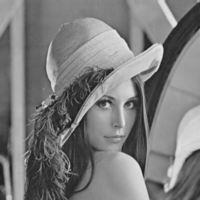

In [32]:
to_pil(lena.data.squeeze(0)) # 原始的lena数据

In [33]:
# lena的形状是1x1x200x200，（N,C,Hin,Win）
w = 400 # 准备将图像放大至400
# 得到400x400的介于[-1,1]之间的均匀分布张量
h_out = t.linspace(-1, 1, w).view(-1, 1).repeat(1, w)
w_out = t.linspace(-1, 1, w).repeat(w, 1)
grid = t.cat((w_out.unsqueeze(2), h_out.unsqueeze(2)), dim = 2)
# grid形状为（N,Hout,Wout,2）
# grid最后一个维度大小为2，表示输入中pixel的位置信息，取值范围在（-1,1）
grid = grid.unsqueeze(0) 

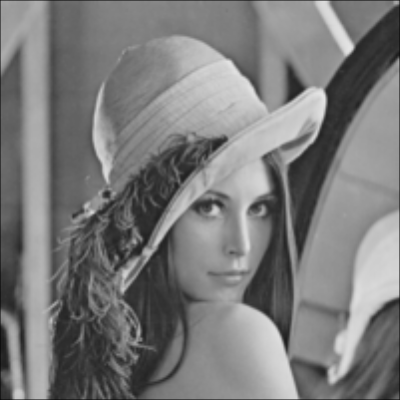

In [34]:
import torch
from torch.nn import functional as F
import warnings
warnings.filterwarnings("ignore")

out = F.grid_sample(lena, grid=grid, mode='bilinear')
to_pil(out.data.squeeze(0))

## 4.4 初始化策略
在深度学习中参数的初始化十分重要，良好的初始化能让模型更快地收敛，并达到更高水平，而糟糕的初始化则可能使得模型迅速崩溃。PyTorch中`nn.Module`的模块参数都采取了较为合理的初始化策略，因此一般不用我们考虑。当然我们也可以用自定义初始化来代替系统的默认初始化。而当我们在使用Parameter时，自定义初始化则尤为重要，这是因为torch.Tensor()返回的是内存中的随机数，很可能会有极大值，这在实际训练网络中会造成溢出或者梯度消失。PyTorch中`nn.init`模块就是专门为初始化而设计的一个模块，其中实现了常用的初始化策略。如果某种初始化策略`nn.init`不提供，用户也可以自己直接初始化。

In [35]:
# 利用nn.init初始化
from torch.nn import init
linear = nn.Linear(3, 4)
t.manual_seed(2021)

init.xavier_normal_(linear.weight)

Parameter containing:
tensor([[ 1.2225,  0.3428, -0.4605],
        [-0.1951, -0.3705,  0.4823],
        [-1.4530, -0.7739,  0.3334],
        [ 0.2577, -1.2324,  0.4905]], requires_grad=True)

In [36]:
# 利用公式，直接初始化
import math
t.manual_seed(2021)

# xavier初始化的计算公式
std = math.sqrt(2) / math.sqrt(7.)
linear.weight.data.normal_(0,std)

tensor([[ 1.2225,  0.3428, -0.4605],
        [-0.1951, -0.3705,  0.4823],
        [-1.4530, -0.7739,  0.3334],
        [ 0.2577, -1.2324,  0.4905]])

In [37]:
# 对模型的所有参数进行初始化
net = Net()
for name, params in net.named_parameters():
    if name.find('linear') != -1:
        # init linear
        params[0] # weight
        params[1] # bias
    elif name.find('conv') != -1:
        pass
    elif name.find('norm') != -1:
        pass

## 4.5 优化器

PyTorch将深度学习中常用的优化方法全部封装在`torch.optim`中，其设计十分灵活，能够很方便地扩展成自定义的优化方法。

所有的优化方法都是继承基类`optim.Optimizer`，并实现了自己的优化步骤。下面就以最基本的优化方法——随机梯度下降法（SGD）举例说明。这里需要重点掌握：

1. 优化方法的基本使用方法；
2. 如何对模型的不同部分设置不同的学习率；
3. 如何调整学习率。

In [38]:
# 以本章4.1节的感知器为例
class Perceptron(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(Perceptron, self).__init__()
        # 此处的Linear是前面自定义的全连接层
        self.layer1 = Linear(in_features, hidden_features) 
        self.layer2 = Linear(hidden_features, out_features)
    def forward(self, x):
        x = self.layer1(x)
        x = t.sigmoid(x)
        return self.layer2(x)

net=Perceptron(3,4,1)

In [39]:
from torch import optim
optimizer = optim.SGD(params=net.parameters(), lr=1)
optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()

input = t.randn(32, 3)
output = net(input)
output.backward(output) # fake backward

optimizer.step() # 执行优化

In [40]:
weight_params = [param for name,param in net.named_parameters() if name.endswith('.w')]
bias_params = [param for name,param in net.named_parameters() if name.endswith('.b')]

optimizer =optim.SGD([
                {'params':bias_params},
                {'params': weight_params, 'lr': 1e-2}
            ], lr=1e-5)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [41]:
# 只为第一个全连接层设置较大的学习率，其余层的学习率较小
special_layers = nn.ModuleList([net.layer1])
special_layers_params = list(map(id, special_layers.parameters()))
base_params = [param for param in net.parameters() if id(param) not in special_layers_params]
optimizer = t.optim.SGD([
            {'params': base_params},
            {'params': special_layers.parameters(), 'lr': 0.01}
        ], lr=0.001 )
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

调整学习率主要有两种做法：
1. 修改optimizer.param_groups中对应的学习率；
2. 新建一个优化器。

相比之下笔者更加推荐第二种做法，这是因为optimizer一般构建开销很小，故而可以构建新的optimizer。但是新建优化器会重新初始化动量等状态信息，这对于使用动量的优化器（如Adam），可能会造成损失函数在收敛过程中出现震荡等情况。

In [42]:
# 调整学习率，新建一个optimizer
old_lr = 0.1
optimizer1 =optim.SGD([
                {'params': bias_params},
                {'params': weight_params, 'lr': old_lr*0.1}
            ], lr=1e-5)
optimizer1

SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.010000000000000002
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [43]:
# 调整学习率, 手动decay, 保存动量
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1 # 学习率为之前的0.1倍
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)

## 4.6 nn.Module深入分析

如果想要更深入地理解nn.Module，研究其原理是很有必要的。首先来看看nn.Module基类的构造函数：
```python
def __init__(self):
    self._parameters = OrderedDict()
    self._modules = OrderedDict()
    self._buffers = OrderedDict()
    self._backward_hooks = OrderedDict()
    self._forward_hooks = OrderedDict()
    self.training = True
```
其中：

- `_parameters`：字典，保存用户直接设置的parameter。例如`self.param1 = nn.Parameter(t.randn(3, 3))`会被检测到，在字典中加入一个key为param，value为对应parameter的item。而self.submodule = nn.Linear(3, 4)中的parameter则不会存于此；
- `_modules`：子module，例如通过`self.submodel = nn.Linear(3, 4)`指定的子module会保存于此；
- `_buffers`：缓存。例如BatchNorm使用Momentum机制，每次前向传播需用到上一次前向传播的结果；
- `_backward_hooks`与`_forward_hooks`：钩子技术，用来提取中间变量；
- `training`：BatchNorm与Dropout层在训练阶段和测试阶段中采取的策略不同，通过判断training值来决定前向传播策略。

上述几个属性中，`_parameters`、`_modules`和`_buffers`这三个字典中的键值，都可以通过`self.key`方式获得，效果等价于`self._parameters['key']`，下面将举例说明。

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 等价与self.register_parameter('param1' ,nn.Parameter(t.randn(3, 3)))
        self.param1 = nn.Parameter(t.rand(3, 3))
        self.submodel1 = nn.Linear(3, 4) 
    def forward(self, input):
        x = self.param1.mm(input)
        x = self.submodel1(x)
        return x
net = Net()
net

Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)

In [45]:
net._modules

OrderedDict([('submodel1', Linear(in_features=3, out_features=4, bias=True))])

In [46]:
net._parameters

OrderedDict([('param1', Parameter containing:
              tensor([[0.9518, 0.6976, 0.2651],
                      [0.0453, 0.1703, 0.0534],
                      [0.6597, 0.9927, 0.1376]], requires_grad=True))])

In [47]:
net.param1 # 等价于net._parameters['param1']

Parameter containing:
tensor([[0.9518, 0.6976, 0.2651],
        [0.0453, 0.1703, 0.0534],
        [0.6597, 0.9927, 0.1376]], requires_grad=True)

In [48]:
for name, param in net.named_parameters():
    print(name, param.size())

param1 torch.Size([3, 3])
submodel1.weight torch.Size([4, 3])
submodel1.bias torch.Size([4])


In [49]:
for name, submodel in net.named_modules():
    print(name, submodel) # 当前module和他的子module

 Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)
submodel1 Linear(in_features=3, out_features=4, bias=True)


In [50]:
bn = nn.BatchNorm1d(2)
input = t.rand(3, 2)
output = bn(input)
bn._buffers

OrderedDict([('running_mean', tensor([0.0397, 0.0299])),
             ('running_var', tensor([0.9065, 0.9008])),
             ('num_batches_tracked', tensor(1))])

从上面的示例中可以看出，`nn.Module`在实际使用中可能层层嵌套：一个module包含若干个子module，每一个子module又包含了更多的子module。为方便用户访问各个子module，`nn.Module`实现了很多方法，如函数`children`可以查看直接子module，函数`modules`可以查看所有的子module（包括当前module）。与之相对应的还有函数`named_childen`和`named_modules`，其能够在返回module列表的同时返回它们的名字。

In [51]:
input = t.arange(0, 12).view(3, 4).float()
model = nn.Dropout()
# 在训练阶段，会有一半左右的数被随机置为0
model(input)

tensor([[ 0.,  2.,  4.,  0.],
        [ 8., 10.,  0.,  0.],
        [ 0., 18., 20.,  0.]])

In [52]:
model.training  = False
# 在测试阶段，dropout什么都不做
model(input)

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]])

对于BatchNorm、Dropout、InstanceNorm等在训练和测试阶段行为差距较大的层，如果在测试时不将其training值设为False，则可能会有很大影响，这在实际使用中要格外注意。虽然可以通过直接设置`training`属性来将子module设为train和eval模式，但这种方式较为繁琐。因为，如果一个模型具有多个Dropout层，就需要为每个Dropout层指定training属性。笔者推荐的做法是调用`model.train()`函数，它会将当前module及其子module中的所有training属性都设为True，相应地，`model.eval()`函数会把training属性都设为False。

In [53]:
net.training, net.submodel1.training

(True, True)

In [54]:
net.eval() # eval()将所有的training属性设为False
net.training, net.submodel1.training

(False, False)

In [55]:
list(net.named_modules())

[('', Net(
    (submodel1): Linear(in_features=3, out_features=4, bias=True)
  )), ('submodel1', Linear(in_features=3, out_features=4, bias=True))]

`register_forward_hook`和`register_backward_hook`函数可以在module前向传播或反向传播时注册钩子。每次前向传播执行结束后会执行钩子函数（hook）。前向传播的钩子函数具有如下形式：`hook(module, input, output) -> None`，而反向传播则具有如下形式：`hook(module, grad_input, grad_output) -> Tensor or None`。钩子函数不应修改输入和输出，并且在使用后应及时删除，以避免每次都运行钩子增加运行负载。钩子函数主要用在获取某些中间结果的情景，如中间某一层的输出或某一层的梯度。这些结果本应写在forward函数中，但如果在forward函数中专门加上这些处理，可能会使处理逻辑比较复杂，这时候使用钩子技术就更加合适。下面考虑一种场景，有一个预训练好的模型，需要提取模型的某一层（不是最后一层）的输出作为特征进行分类，但又不希望修改其原有的模型定义文件，这时就可以利用钩子函数。下面给出实现的伪代码。
```python
model = VGG()
features = t.Tensor()
def hook(module, input, output):
    '''把这层的输出拷贝到features中'''
    features.copy_(output.data)
    
handle = model.layer8.register_forward_hook(hook)
_ = model(input)
# 用完hook后删除
handle.remove()
```

`nn.Module`对象在构造函数中的行为看起来有些怪异，如果想要真正掌握其原理，就需要看两个魔法方法`__getattr__`和`__setattr__`。在Python中有两个常用的buildin方法`getattr`和`setattr`。

1. 对于`getattr(obj, 'attr1')`，其等价于`obj.attr`，如果`getattr`函数无法找到所需属性，Python会调用`obj.__getattr__('attr1')`方法，即`getattr`函数无法找到的交给`__getattr__`函数处理；如果这个对象没有实现`__getattr__`方法，或者遇到`__getattr__`方法也无法处理情况，程序就会抛出异常AttributeError。
2. 对于`setattr(obj, 'name', value)`，其等价于`obj.name=value`，如果obj对象实现了`__setattr__`方法，`setattr`会直接调用`obj.__setattr__('name', value)`，否则调用buildin方法。

总结如下：

- result  = obj.name会调用buildin函数`getattr(obj, 'name')`，如果该属性找不到，则会调用`obj.__getattr__('name')`
- obj.name = value会调用buildin函数`setattr(obj, 'name', value)`，如果obj对象实现了`__setattr__`方法，`setattr`会直接调用`obj.__setattr__('name', value)`

nn.Module实现了自定义的`__setattr__`函数，当执行`module.name=value`时，会在`__setattr__`中判断value是否为`Parameter`或`nn.Module`对象，如果是则将这些对象加到`_parameters`和`_modules`两个字典中；而如果是其它类型的对象，如`list`、`dict`等，则调用默认的操作，将这个值保存在`__dict__`中。

In [56]:
module = nn.Module()
module.param = nn.Parameter(t.ones(2, 2))
module._parameters

OrderedDict([('param', Parameter containing:
              tensor([[1., 1.],
                      [1., 1.]], requires_grad=True))])

In [57]:
submodule1 = nn.Linear(2, 2)
submodule2 = nn.Linear(2, 2)
module_list = [submodule1, submodule2]
# 对于list对象，调用buildin函数，保存在__dict__中
module.submodules = module_list
print('_modules: ', module._modules)
print("__dict__['submodules']:",module.__dict__.get('submodules'))

_modules:  OrderedDict()
__dict__['submodules']: [Linear(in_features=2, out_features=2, bias=True), Linear(in_features=2, out_features=2, bias=True)]


In [58]:
module_list = nn.ModuleList(module_list)
module.submodules = module_list
print('ModuleList is instance of nn.Module: ', isinstance(module_list, nn.Module))
print('_modules: ', module._modules)
print("__dict__['submodules']:", module.__dict__.get('submodules'))

ModuleList is instance of nn.Module:  True
_modules:  OrderedDict([('submodules', ModuleList(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
))])
__dict__['submodules']: None


因`_modules`和`_parameters`中的item未保存在`__dict__`中，所以默认的`getattr`方法无法获取它，因而`nn.Module`实现了自定义的`__getattr__`方法。如果默认的`getattr`无法处理，就调用自定义的`__getattr__`方法，尝试从`_modules`、`_parameters`和`_buffers`这三个字典中获取。

In [59]:
getattr(module, 'training') # 等价于module.training
# error
# module.__getattr__('training')

True

In [60]:
module.attr1 = 2
getattr(module, 'attr1')
# 报错
# module.__getattr__('attr1')

2

In [61]:
# 即module.param, 会调用module.__getattr__('param')
getattr(module, 'param')

Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

在PyTorch中保存模型十分简单，所有的Module对象都具有state_dict()函数，返回当前Module所有的状态数据。将这些状态数据保存后，下次使用模型时即可利用`model.load_state_dict()`函数将状态加载进来。优化器（optimizer）也有类似的机制，不过一般并不需要保存优化器的运行状态。

In [62]:
# 保存模型
t.save(net.state_dict(), 'net.pth')

# 加载已保存的模型
net2 = Net()
net2.load_state_dict(t.load('net.pth'))

<All keys matched successfully>

实际上还有另外一种保存方法，但因其严重依赖模型定义方式及文件路径结构等，很容易出问题，因而不建议使用。

In [63]:
t.save(net, 'net_all.pth')
net2 = t.load('net_all.pth')
net2

Net(
  (submodel1): Linear(in_features=3, out_features=4, bias=True)
)

将Module放在GPU上运行也十分简单，只需以下两步：
- model = model.cuda()：将模型的所有参数转存到GPU；
- input.cuda()：将输入数据放置到GPU上。

至于如何在多个GPU上并行计算，PyTorch也提供了两个函数，可实现简单高效的并行GPU计算。

- nn.parallel.data_parallel(module, inputs, device_ids=None, output_device=None, dim=0, module_kwargs=None)
- class torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)

可见二者的参数十分相似，通过`device_ids`参数可以指定在哪些GPU上进行优化，而通过`output_device`参数可以指定输出到哪个GPU上。二者唯一的不同就在于前者直接利用多GPU并行计算得出结果，而后者则返回一个新的module，能够自动在多GPU上进行并行加速。

```
# method 1
new_net = nn.DataParallel(net, device_ids=[0, 1])
output = new_net(input)

# method 2
output = nn.parallel.data_parallel(new_net, input, device_ids=[0, 1])
```

DataParallel并行的方式，是将输入一个batch的数据均分成多份，分别送到对应的GPU进行计算，各个GPU得到的梯度累加。与Module相关的所有数据也都会以浅复制的方式复制多份。

## 4.7 小试牛刀：搭建ResNet
Kaiming He提出的深度残差网络（ResNet）在深度学习的发展中起到了很重要的作用，ResNet不仅一举拿下了当年多个计算机视觉比赛项目的冠军，更重要的是这一结构解决了训练极深网络时的梯度消失问题。

这里选取的是ResNet的一个变种ResNet34来讲解ResNet的网络结构。ResNet的网络结构如图4-2所示，除了最开始的卷积池化和最后的池化全连接之外，网络中有很多结构相似的单元，这些重复单元的共同点就是有个跨层直连的shortcut。ResNet中将一个跨层直连的单元称为Residual Block，其结构如图4-3所示，左边部分是普通的卷积网络结构，右边是直连，但如果输入和输出的通道数不一致，或其步长不为1，那么就需要有一个专门的单元将二者转成一致，使其可以相加。

另外我们可以发现Residual Block的大小也是有规律的，在最开始的pool之后有连续的几个一模一样的Residual Block单元，这些单元的通道数一样，在这里我们将这几个拥有多个Residual Block单元的结构称之为layer。读者需要将这里的layer和之前讲的layer区分开来，这里的layer是几个层的集合。

考虑到Residual Block和layer出现了多次，我们可以把它们实现为一个子Module或函数。这里我们将Residual Block实现为一个子module，而将layer实现为一个函数。下面是实现代码，规律总结如下：

- 对于模型中的重复部分，实现为子module或用函数生成相应的module；
- nn.Module和nn.Functional结合使用；
- 尽量使用`nn.Seqential`。

![图4-2: ResNet34网络结构](imgs/resnet1.png)

![图4-3: Residual block 结构图](imgs/residual.png)


In [64]:
from torch import  nn
import torch as t
from torch.nn import  functional as F

In [65]:
class ResidualBlock(nn.Module):
    '''
    实现子module: Residual Block
    '''
    def __init__(self, inchannel, outchannel, stride=1, shortcut=None):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
                nn.Conv2d(inchannel,outchannel,3,stride,1,bias=False),
                nn.BatchNorm2d(outchannel),
                nn.ReLU(inplace=True),
                nn.Conv2d(outchannel,outchannel,3,1,1,bias=False),
                nn.BatchNorm2d(outchannel) )
        self.right = shortcut

    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out += residual
        return F.relu(out)

class ResNet(nn.Module):
    '''
    实现主module：ResNet34
    ResNet34 包含多个layer，每个layer又包含多个residual block
    用子module来实现residual block，用_make_layer函数来实现layer
    '''
    def __init__(self, num_classes=1000):
        super(ResNet, self).__init__()
        # 前几层图像转换
        self.pre = nn.Sequential(
                nn.Conv2d(3, 64, 7, 2, 3, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(3, 2, 1)
        )
        
        # 重复的layer，分别有3，4，6，3个Residual Block
        self.layer1 = self._make_layer(64, 64, 3, 1, is_shortcut=False)
        self.layer2 = self._make_layer(64,  128, 4, 2)
        self.layer3 = self._make_layer(128, 256, 6, 2)
        self.layer4 = self._make_layer(256, 512, 3, 2)

        # 分类用的全连接
        self.classifier = nn.Linear(512, num_classes)
    
    def _make_layer(self, inchannel, outchannel, block_num, stride, is_shortcut=True):
        '''
        构建layer,包含多个residual block
        '''
        if is_shortcut:
            shortcut = nn.Sequential(
                    nn.Conv2d(inchannel,outchannel,1,stride, bias=False),
                    nn.BatchNorm2d(outchannel))
        else:
            shortcut = None
        
        layers = []
        layers.append(ResidualBlock(inchannel, outchannel, stride, shortcut))
        
        for i in range(1, block_num):
            layers.append(ResidualBlock(outchannel, outchannel))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.pre(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = F.avg_pool2d(x, 7)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [66]:
model = ResNet()
input = t.randn(1, 3, 224, 224)
out = model(input)

感兴趣的读者可以尝试实现一下Google的Inception网络结构或ResNet的其它变体，看看如何能够简洁明了地实现这些经典的网络结构。另外，与PyTorch配套的图像工具包`torchvision`已经实现了深度学习中大多数经典的模型，其中就包括ResNet34，读者可以通过下面两行代码使用：
```python
from torchvision import models
model = models.resnet34()
```
关于`torchvision`的具体内容将在本书第五章进行讲解，通过torchvision我们便可以方便地使用深度学习中经典的网络模型了。

## 本章小结

本章详细介绍了神经网络工具箱nn的使用。首先本章对神经网络中常用层结构进行了介绍，并举例说明了如何使用`nn.Module`模块来实现这些常用的层结构；其次，本章对`nn.Module`进行了深入剖析，并详细介绍了其构造函数与两种魔法方法；同时，本章还对神经网络中的初始化策略与优化器进行了详细讲解；最后，本章运用`nn.Module`模块实现了经典的ResNet网络结构。通过本章的学习，读者可以掌握神经网络工具箱中大部分类和函数的用法，并按照实际需要搭建自己的网络结构。